# Generativity and Adversarial Gradients

**Purpose:** Quick check to assert that the adversiarial gradients point to the same object (and not just a copy of weights). 

note: git commit `f241a9c` , if there is an error and it is fixed, this notebook will not run appropriately

**Result:** Matrices do not refer to the same object. I believe the transpose operation is copying a new object. 

# Imports

In [161]:
from typing import List

import copy
import os
import pathlib

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# In case you are fortunate enough to have access to a GPU...
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"using {device = }")

using device = 'cuda'


# Plotting

In [172]:
def draw(X, img_size: (28,28)):
    def draw_single(x): 
        with torch.no_grad():
            plt.imshow(x.detach().cpu().numpy().reshape(img_size), cmap='gray');
            plt.axis('off');

    if len(X.shape)==4 or len(X.shape)==2:  # display a batch
        N = X.shape[0]
        plt.figure(figsize=(15,3))
        for k,xx in enumerate(X):
            plt.subplot(1,10,k+1)
            draw_single(xx)
    else:
        draw_single(X)

# Data: MNIST

In [3]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_full = torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=T.Compose([
                                T.Resize((img_size,img_size)),
                                T.ToTensor(),
                                T.Lambda((lambda x: torch.flatten(x))),
                            ]))

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./files/MNIST\raw\train-images-idx3-ubyte.gz to ./files/MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./files/MNIST\raw\train-labels-idx1-ubyte.gz to ./files/MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./files/MNIST\raw\t10k-images-idx3-ubyte.gz to ./files/MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./files/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./files/MNIST\raw

Processing...
Done!


C:\Users\bcech\anaconda3\envs\adv\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# You can change img_size to 14 if you want to use smaller (14x14) images.
img_size = 28
ds_test = torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=T.Compose([
                                T.Resize((img_size,img_size)),
                                T.ToTensor(),
                                T.Lambda((lambda x: torch.flatten(x))),
                            ]))

In [5]:
#ds = ds_full
n = 1024*2
n_samples = n if n <= len(ds_full) else len(ds_full)

ds = torch.utils.data.Subset(ds_full, range(n_samples))
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=256)

# Network

In [248]:
class MyNet(nn.Module):
    '''
     net = MyNet(img_size=28)
     
     Creates a neural network to do classification on MNIST.
     It assumes the images will be (img_size)x(img_size).
     
     It projects to a latent space.
     From that latent space, it:
      1) projects to an output classification layer (log softmax), and
      2) projects back down through the network to a reconstruction of the input.
     
    '''
    def __init__(self, img_size=28, latent_dim=5):
        super().__init__()
        
        # Discriminative network
        self.D = nn.ModuleList()
        
        # Input -> Hidden 1
        self.D.append(nn.Linear(img_size**2, 100))
        self.D.append(nn.ReLU())
        
        # Hidden 1 -> Hidden 2
        self.D.append(nn.Linear(100, latent_dim))
        self.D.append(nn.ReLU())
        
        # Classifier
        self.classifier = nn.Sequential(
                            nn.Linear(latent_dim, 10),
                            nn.LogSoftmax(dim=-1),
                            )

        # The generative network
        self.G = nn.ModuleList()
        
        # Hidden 2 -> Hidden 1
        self.G.append(nn.Linear(latent_dim, 100))
        self.G.append(nn.ReLU())
        
        # Hidden 1 -> Input
        self.G.append(nn.Linear(100, img_size**2))
        self.G.append(nn.Sigmoid())
        
        # Tie the weights of D and G
        #TODO check if pointer or copy
        # check pytorch source to see transpose
        # https://pytorch.org/docs/stable/generated/torch.transpose.html#torch.transpose
        # ^ shares underlying data, so will not return new object
        self.G[-2].weight.data = self.D[0].weight.data.transpose(1,0)
        self.G[-4].weight.data = self.D[2].weight.data.transpose(1,0)
        self.G[-4].bias.data = self.D[0].bias.data
        
        self.classifier_loss = nn.NLLLoss()
        self.recon_loss = nn.BCELoss()
        self.losses = []
        self.to(device)
        
        # checkpoint states
        self.optimizer = None
        
        
    def forward(self, x):
        '''Latent -> Classification'''
        return self.classifier(self.discriminate(x))

    
    def ae(self,x):
        return self.generate(self.discriminate(x))

    
    def discriminate(self, x):
        '''Input -> Latent'''
        for d in self.D:
            x = d(x)
        return x


    def generate(self, z):
        '''
         Latent -> Input
         x_had = net.generate(z)
         
         Runs the network in reverse, generating a batch of inputs from
         a batch of latent vectors.
         
         Inputs:
          z      (D,latent_dim) tensor of latent vectors
          
         Outputs:
          x_hat  (D,784) tensor containing the batch of inputs
        '''
        for g in self.G:
            z = g(z)
        return z
    
      
    def learn(self, 
              dl, 
              optimizer=None, 
              epochs=10, 
              beta=0.,
              checkpoints=[],
              path: str=None,
              plot_loss=True):
        '''
         net.learn(dl, optimizer=None, epochs=10, beta=0.)
         
         Train the network on the dataset represented by the DataLoader dl.
         The default optimizer is Adam().
         
         The targets for the dataset are assumed to be class indices.
         
         beta is the weight for the reconstruction loss.
         
         Args:
             dl (Dataloader): 
             checkpoints (Boolean|List[int]): if True, save every 10-epochs. if List[int], save each listed epoch.
             path (str): optional path to save model checkpoints.
        '''
        if optimizer is None:
            print('Need to specify an optimizer')
            return
        else:
            self.optimizer = optimizer
        
        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            count = 0.
            for x, t in dl:
                x = x.to(device)   # for use with a GPU
                t = t.to(device)
                z = self.discriminate(x)
                y = self.classifier(z)
                xhat = self.generate(z)
                loss = self.classifier_loss(y, t) + beta*self.recon_loss(xhat, x)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # set generator weights to equal discirminator weights
                # hack fix
                #self.G[0].weight.data = self.D[2].weight.data.transpose(1,0)
                #self.G[-2].weight.data = self.D[0].weight.data.transpose(1,0)
                self.G[-2].weight = torch.nn.Parameter(self.D[0].weight.transpose(1,0))
                self.G[-4].weight = torch.nn.Parameter(self.D[2].weight.transpose(1,0))
                # delete above hack
                total_loss += loss.item()*len(t)
                count += 1.
            self.losses.append(total_loss/len(dl.dataset))
            #print(f'Epoch: {epoch}, loss: {total_loss/count}')
            if checkpoints:
                self.checkpoint(epoch, checkpoints, path)
        
        if plot_loss:        
            plt.figure(figsize=(4,4))
            plt.plot(self.losses); plt.yscale('log');


    def checkpoint(self, 
                   epoch: int, 
                   checkpoints: List[int]=[],
                   path: str="model-checkpoints.pt"):
        """ Save model checkpoints. 
        
            Args:
                epoch (int): Current training epoch.
                checkpoints (List[int]): list of epochs to save model at. if True, save every 10.model 
                path (str): path to save model.pt
                
        """
        
        def save_checkpoint(self, epoch, path):
            path = path.split(".pt")[0] + f"-{epoch}" + ".pt"
            torch.save({'epoch': epoch,
                        'model_state_dict': self.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'loss': self.losses[-1],
                        }, 
                        path) 
        
        if checkpoints is True:
            if epoch % 10 == 0: 
                save_checkpoint(self, epoch, path)
        elif epoch in checkpoints:
            save_checkpoint(self, epoch, path)     

# Assert Objects

In [105]:
net = MyNet(28, latent_dim=8)#.to(device)

Below: The tensors start out with identical weight values

In [ ]:
#         self.G[-2].weight.data = self.D[0].weight.data.transpose(1,0)
#         self.G[-4].weight.data = self.D[2].weight.data.transpose(1,0)

In [247]:
assert torch.equal(net.G[-2].weight.data.T, net.D[0].weight.data)
assert torch.equal(net.G[-4].weight.data.T, net.D[2].weight.data)

In [115]:
assert torch.equal(net.G[0].weight.data.T, net.D[2].weight.data)
assert torch.equal(net.G[-2].weight.data.T, net.D[2].weight.data)

Below: but the pointers do not reference the same object

In [113]:
assert net.G[-2].weight.data is net.D[0].weight.data.transpose(1,0)
assert net.G[-4].weight.data is net.D[2].weight.data.transpose(1,0)
assert net.G[-4].bias.data is net.D[0].bias.data.transpose(1,0)

AssertionError: 

In [116]:
assert net.G[-2] is net.D[0]
assert net.G[-4] is net.D[2]
assert net.G[-4] is net.D[0]

AssertionError: 

In [201]:
assert net.G[-2].weight.data is net.D[0].weight.data.transpose(1,0)
assert net.G[-4].weight is net.D[2].weight
assert net.G[-4].bias is net.D[0].bias

AssertionError: 

Looks like these asserts will fail, not because the pointers aren't to the same object, but because the transpose operation breaks the `is` comparison. 

So, have to just test if updates to one affect the other

In [118]:
#TODO check if pointer or copy
#self.G[-2].weight.data = self.D[0].weight.data.transpose(1,0)

Consider the zero-th row of `net.G[-2]` and the zero-th column of `net.D[0]` should be equivalent

Below: on update of generator, discriminator weights shouldn't change

In [122]:
net.G[-2].weight.data[0:1,] = 1

assert not net.G[-2].weight.data is net.D[0].weight.data

Below: but on update of discriminator, generator _should_ update

In [142]:
net.D[0].weight.data[0:1,] = 9

assert torch.equal(net.D[0].weight.data[0:1,], net.G[-2].weight.data.transpose(1,0)[0:1,])

AssertionError: 

Below: but forcing a chage to `net.G` does update.

In [146]:
net.G[-2].weight.data[:,0] = 9

assert torch.equal(net.D[0].weight.data[0:1,], net.G[-2].weight.data.transpose(1,0)[0:1,])

# Train Net and Assert Weights

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.14s/it]


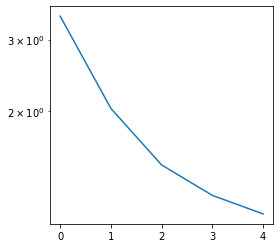

In [249]:
img_size = 28
net = MyNet(img_size, latent_dim=8)#.to(device)

g_init = net.G[-2].weight.data
d_init = net.D[0].weight.data

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
checkpoints = False
#path = f"data/mnist-{len(dl)}-checkpoint.pt"

net.learn(dl, 
          optimizer=optimizer, 
          epochs=5, 
          beta=3., 
          checkpoints=checkpoints)

In [ ]:
#.G[-2].weight.data = self.D[0]

In [250]:
assert torch.equal(net.G[-2].weight.data.T, net.D[0].weight.data)
assert torch.equal(net.G[-4].weight.data.T, net.D[2].weight.data)

AssertionError: 

Again: `net.D` gradient indices are `0->2` (and bias at `0`).   while `net.G` gradients, are the reverse `-4 -> -2`.  

In [240]:
d = [0, 2]
g = [-2,-4]


for i,j in zip(g,d):
    print(f"for {i=}, {j=}")
    assert torch.equal(net.G[i].weight.data, net.D[j].weight.data.T)

for i=-2, j=0
for i=-4, j=2


In [241]:
net.G[-2].weight.data[:5,:5]

tensor([[-0.1015, -0.0661, -0.0799, -0.0959, -0.0570],
        [-0.0944, -0.0668, -0.0944, -0.0583, -0.0533],
        [-0.1062, -0.0993, -0.0823, -0.0813, -0.1034],
        [-0.0418, -0.1196, -0.0709, -0.0585, -0.0916],
        [-0.0591, -0.0511, -0.0514, -0.0741, -0.0876]], device='cuda:0')

In [242]:
net.D[0].weight.data[:5,:5]

tensor([[-0.1015, -0.0944, -0.1062, -0.0418, -0.0591],
        [-0.0661, -0.0668, -0.0993, -0.1196, -0.0511],
        [-0.0799, -0.0944, -0.0823, -0.0709, -0.0514],
        [-0.0959, -0.0583, -0.0813, -0.0585, -0.0741],
        [-0.0570, -0.0533, -0.1034, -0.0916, -0.0876]], device='cuda:0')

In [62]:
assert not torch.equal(g_init, net.G[-2].weight.data)

AssertionError: 

In [63]:
assert not torch.equal(d_init, net.D[0].weight.data)

AssertionError: 

## Check object IDs

and maybe memory location

note: ID is of the pointer, not the object, it seems.

In [67]:
id(net.G[-2].weight.data)

2905600556160

In [68]:
id(net.D[0].weight.data)

2905600495424

In [71]:
net.G[-2].weight.data[0:1,].shape

torch.Size([1, 100])

In [72]:
net.D[0].weight.data[:,0:1].T.shape

torch.Size([1, 100])

# Check Training Checkpoints

Does generator update through training?

In [212]:
img_size = 28
net = MyNet(img_size, latent_dim=8)#.to(device)

g_init = net.G[-2].weight.data
d_init = net.D[0].weight.data
assert torch.equal(d_init, g_init.transpose(1,0))

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
checkpoints = [0,1,5,10,20,49]
path = f"../data/06_models/debug/mnist-train-{len(ds)}-checkpoint.pt"

net.learn(dl, 
          optimizer=optimizer, 
          epochs=50, 
          beta=3., 
          checkpoints=checkpoints,
          path=path,
          plot_loss=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.04s/it]


In [204]:
paths = [filepath.absolute() for filepath in pathlib.Path("../data/06_models/debug").glob("*.pt")]
model = copy.deepcopy(net)    # just in case, don't mess with net obj

# history of net.G[-2]
g_history = []
d_history = []
print("plotting epochs:", end=" ")
for path in paths:
    
    # load model checkpoint
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    model.eval()

    g_checkpoint = model.G[-2].weight.data
    d_checkpoint = model.D[0].weight.data
    
    g_history.append(g_checkpoint)
    d_history.append(d_checkpoint)
    
    # draw grad subplot line
    #print(f"{epoch}", end=", ")
    #draw(torch.sign(x.grad[:10]))
    
    #draw(g_checkpoint, img_size=(784,100))
    
    print(g_checkpoint[:5,:5])

plotting epochs: tensor([[-0.0574, -0.0941,  0.0096, -0.0116, -0.0820],
        [-0.0474, -0.0366,  0.0263,  0.0027, -0.0407],
        [-0.0489, -0.0431,  0.0134,  0.0253, -0.0301],
        [-0.0734, -0.0308, -0.0329,  0.0169, -0.0913],
        [-0.0394, -0.0712, -0.0319, -0.0186, -0.0887]], device='cuda:0')
tensor([[-0.0734, -0.1089,  0.0096, -0.0116, -0.0936],
        [-0.0637, -0.0518,  0.0263,  0.0027, -0.0527],
        [-0.0653, -0.0583,  0.0134,  0.0253, -0.0421],
        [-0.0896, -0.0459, -0.0329,  0.0169, -0.1032],
        [-0.0555, -0.0862, -0.0319, -0.0186, -0.1006]], device='cuda:0')
tensor([[-0.0805, -0.1144,  0.0096, -0.0116, -0.0981],
        [-0.0711, -0.0576,  0.0263,  0.0027, -0.0573],
        [-0.0726, -0.0643,  0.0134,  0.0253, -0.0467],
        [-0.0968, -0.0517, -0.0329,  0.0169, -0.1078],
        [-0.0629, -0.0919, -0.0319, -0.0186, -0.1052]], device='cuda:0')
tensor([[-0.0845, -0.1172,  0.0096, -0.0116, -0.1017],
        [-0.0753, -0.0605,  0.0263,  0.0027, -0.0

In [211]:
assert torch.equal(d_init, g_init.transpose(1,0)) # passes on network instantiation above

AssertionError: 

above: since `d_init` and `g_init` are pointers to the network's respective tensors, the assert passing on instantiation, but failing after training (again) indicates that the two matrices diverge throughout training.

In [207]:
for i in range(len(d_history)):
    print(f"{i = }")
    assert torch.equal(d_history[i], g_history[i].transpose(1,0))

i = 0


AssertionError: 

Check again with higher gradients

In [177]:
paths = [filepath.absolute() for filepath in pathlib.Path("../data/06_models/debug").glob("*.pt")]
model = copy.deepcopy(net)    # just in case, don't mess with net obj

# history of net.G[-4]
g_history = []
d_history= []

print("plotting epochs:", end=" ")
for path in paths:
    
    # load model checkpoint
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    model.eval()

    g_checkpoint = model.G[-4].weight.data
    d_checkpint = model.D[0].weight.data
    
    # draw grad subplot line
    #print(f"{epoch}", end=", ")
    #draw(torch.sign(x.grad[:10]))
    
    #draw(g_checkpoint, img_size=(100,8))
    print(g_checkpoint[:5,:5])

plotting epochs: torch.Size([100, 8])
tensor([[ 0.0415,  0.0580,  0.0540,  0.0311,  0.1034],
        [ 0.0508, -0.0376, -0.0172,  0.0172,  0.0869],
        [ 0.0680,  0.0222,  0.0593,  0.0096, -0.0155],
        [-0.0193,  0.0904,  0.0055,  0.0258,  0.0173],
        [ 0.0626,  0.0281,  0.0178, -0.0091,  0.0475]], device='cuda:0')
torch.Size([100, 8])
tensor([[ 0.0428,  0.0485,  0.0613,  0.0073,  0.1034],
        [ 0.0530, -0.0605, -0.0155,  0.0026,  0.0849],
        [ 0.0720, -0.0166,  0.0584, -0.0105, -0.0232],
        [-0.0228,  0.0830, -0.0095,  0.0110,  0.0183],
        [ 0.0667,  0.0209, -0.0181, -0.0191,  0.0474]], device='cuda:0')
torch.Size([100, 8])
tensor([[ 0.0312,  0.0788, -0.0034, -0.0635,  0.1462],
        [ 0.0690, -0.1749, -0.0151, -0.0057,  0.1857],
        [ 0.0468, -0.0423,  0.0839, -0.0662, -0.0208],
        [-0.0431,  0.2251, -0.2423, -0.0761, -0.0344],
        [ 0.0628,  0.0977, -0.1439, -0.0560,  0.0781]], device='cuda:0')
torch.Size([100, 8])
tensor([[ 0.0539,  0

# Check on Arbitrary Tensors

**Shows**: that referencing a torch tensor pointer can work, update, and not create a copy

In [192]:
a = torch.rand((2,4))
b = a.transpose(1,0)

In [193]:
print(id(a))
print(id(b))

2905902216768
2905902433856


In [194]:
a

tensor([[0.6806, 0.2511, 0.9525, 0.2058],
        [0.9230, 0.0633, 0.9435, 0.4459]])

In [195]:
a[0,:] = 9
b
assert torch.equal(b[:,0], torch.tensor([9.]*4))

In [196]:
 torch.tensor([9]*4)

tensor([9, 9, 9, 9])

In [197]:
b[:,0]

tensor([9., 9., 9., 9.])

In [200]:
torch.equal(a, b.transpose(1,0))

True

# Fix

In [223]:
id(net.G[-2].__dict__['_parameters']['weight'].data)

2905784361984

In [224]:
id(net.D[2].__dict__['_parameters']['weight'].data)

2905784361472

In [225]:
net.G[-2].__dict__['_parameters']['weight'].data

tensor([[-0.0521, -0.0775, -0.0744,  ..., -0.0725, -0.1654, -0.1301],
        [-0.0731, -0.0631, -0.0613,  ..., -0.0661, -0.2164, -0.1361],
        [-0.0520, -0.0943, -0.1003,  ..., -0.0813, -0.2067, -0.1428],
        ...,
        [-0.0612, -0.0680, -0.0747,  ..., -0.0412, -0.2129, -0.1440],
        [-0.0582, -0.0743, -0.0969,  ..., -0.0999, -0.1562, -0.1525],
        [-0.0906, -0.0473, -0.0539,  ..., -0.0384, -0.1802, -0.1583]],
       device='cuda:0')

In [ ]:
aa